Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
有效评论数: 1000
提取的关键词: ['一般' '下次' '不好' '口感' '地方' '广州' '服务态度' '海底' '特别' '环境']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     13.73
Date:                Fri, 13 Jun 2025   Prob (F-statistic):           4.82e-17
Time:                        15:57:58   Log-Likelihood:                 446.96
No. Observations:                1000   AIC:                            -877.9
Df Residuals:                     992   BIC:                            -838.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                       

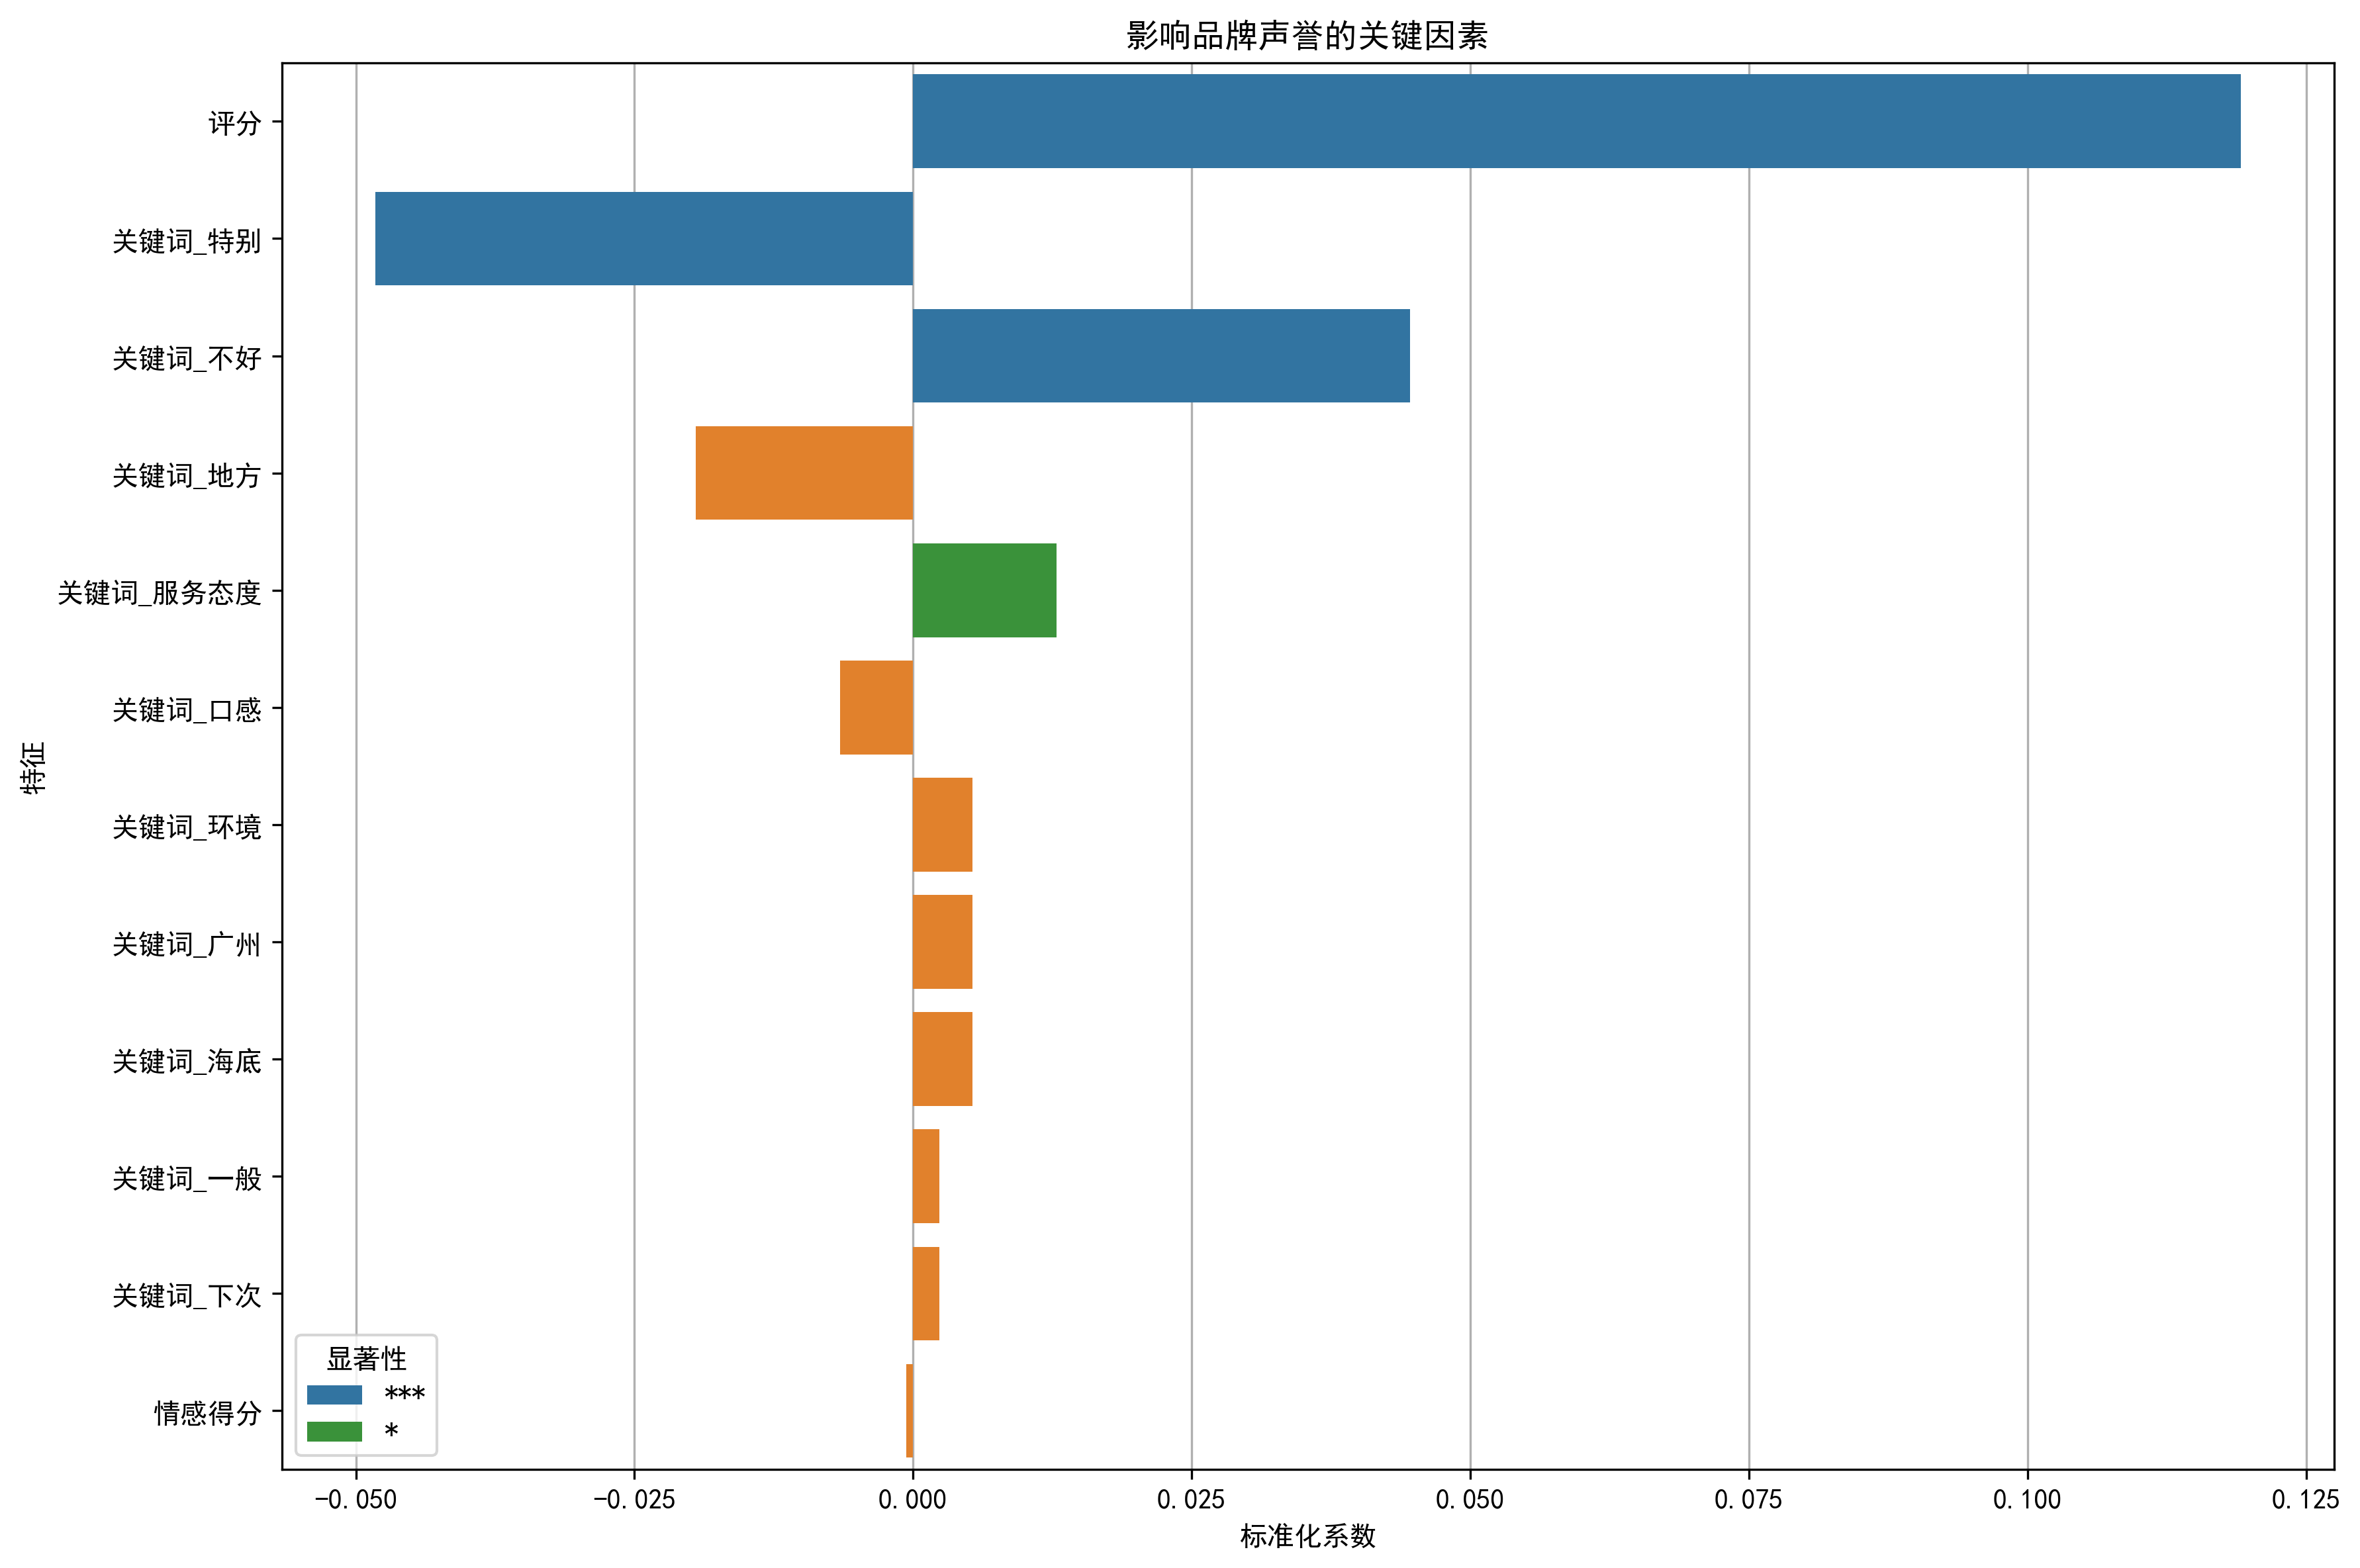

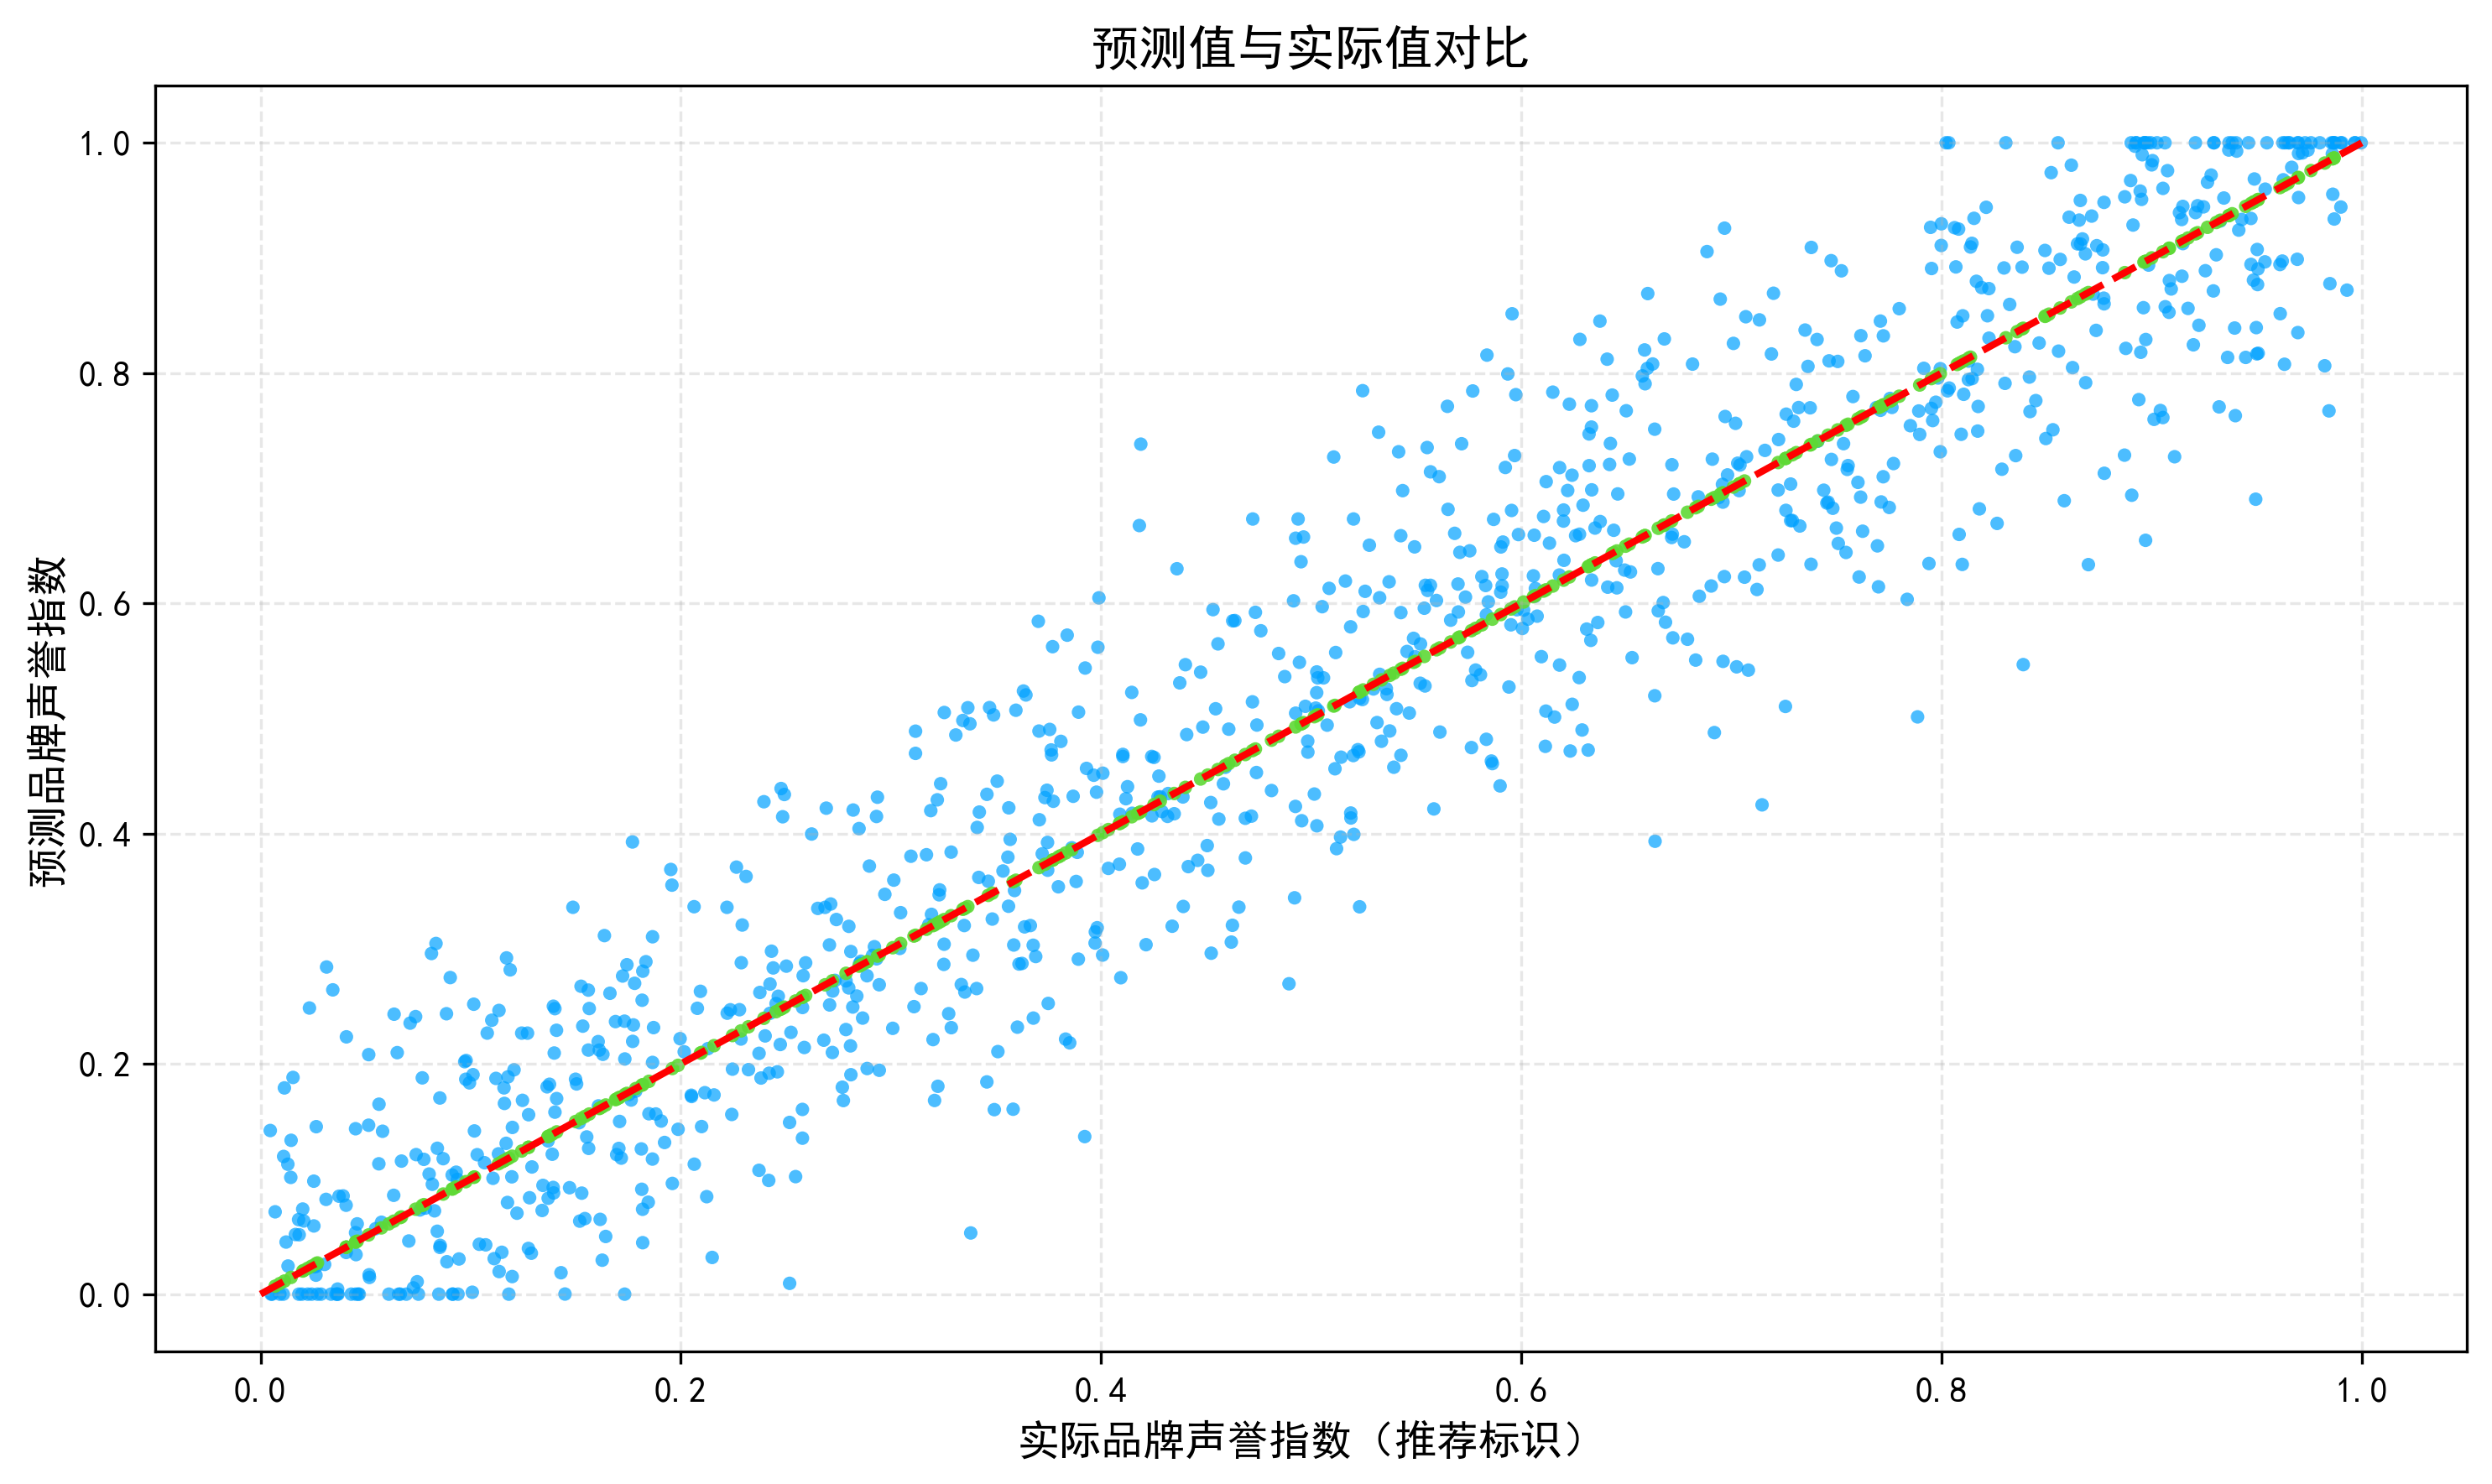

数据处理或模型构建出错: "No such keys(s): 'mode.use_inf_as_null'"


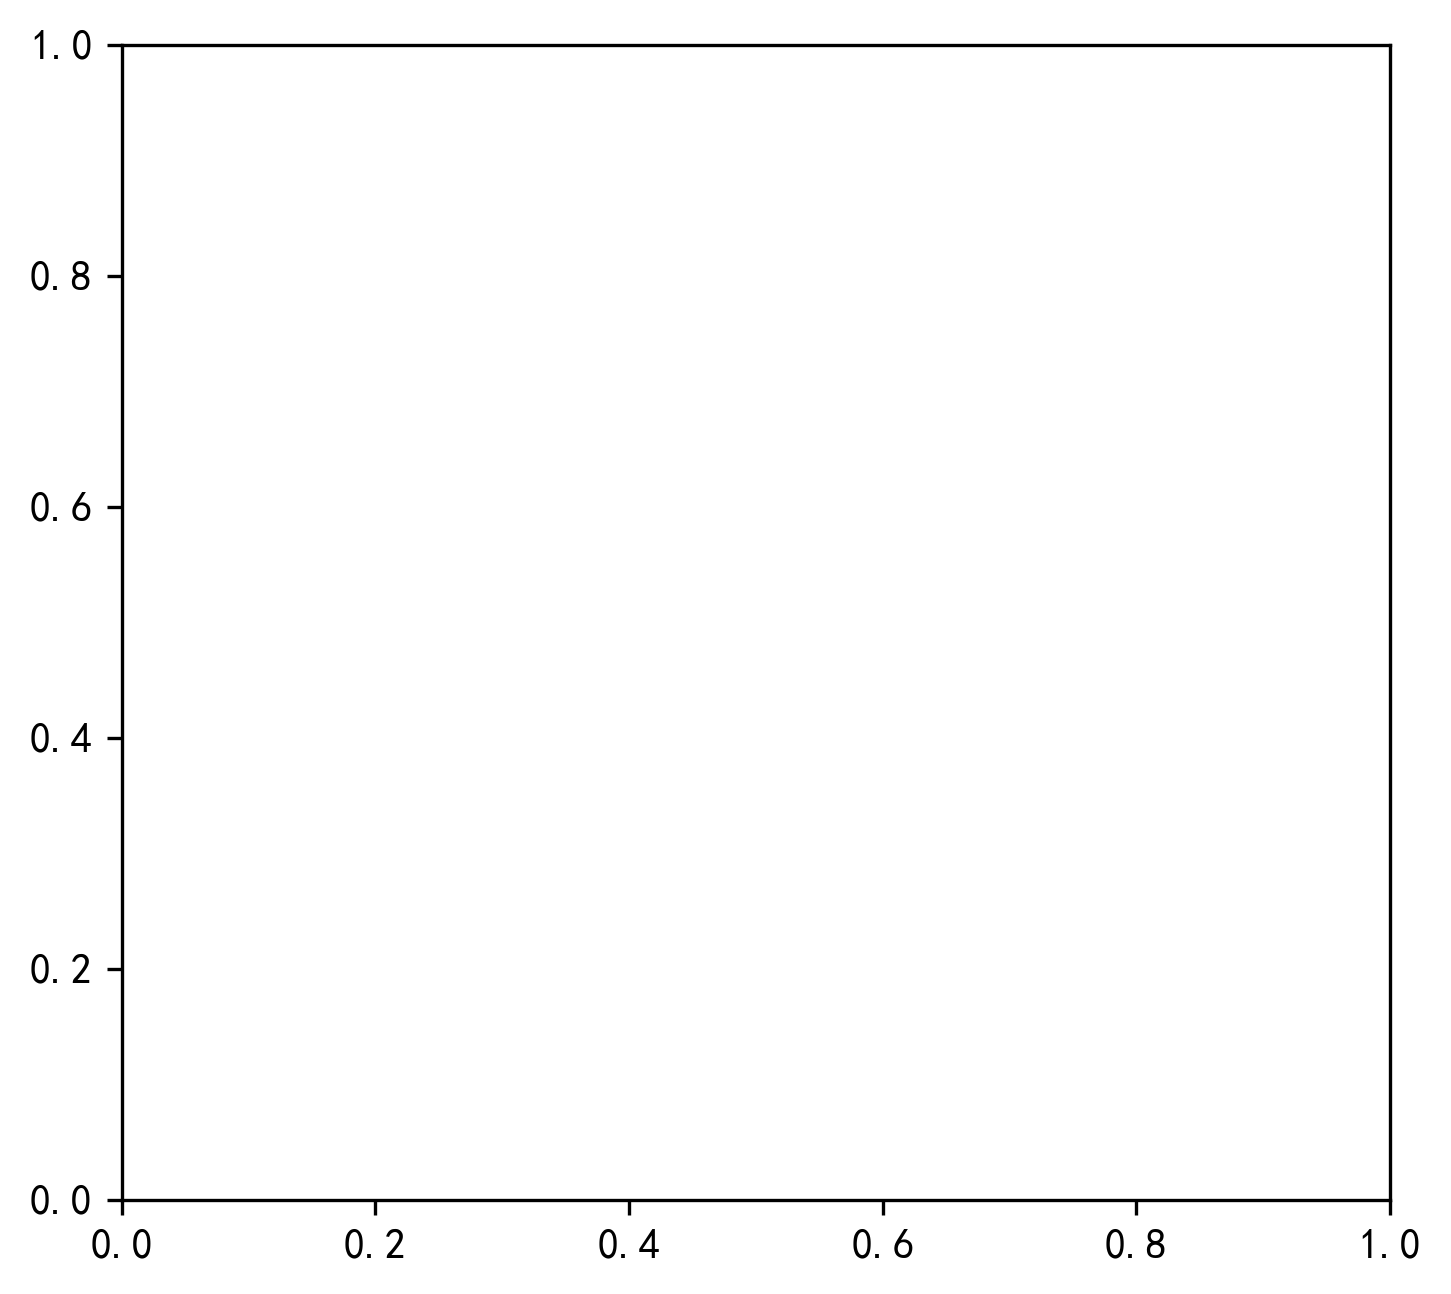

In [23]:
# 使用清华镜像源安装必要的库
!pip install numpy matplotlib seaborn statsmodels scikit-learn jieba snownlp openpyxl -i https://pypi.tuna.tsinghua.edu.cn/simple

# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import jieba
from snownlp import SnowNLP
from openpyxl import load_workbook
import os

# 设置中文显示及图表清晰度
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

# 读取Excel数据
def read_excel_file(file_path):
    try:
        wb = load_workbook(file_path, read_only=True)
        sheet = wb.active
        header = [cell.value for cell in sheet[1]]
        data = []
        for row in sheet.iter_rows(min_row=2):
            row_data = [cell.value for cell in row]
            data.append(row_data)
        wb.close()
        return header, data
    except Exception as e:
        print(f"读取文件出错: {e}")
        return None, None

# 生成模拟的实际值与预测值
def generate_simulation_data(n=1000):
    np.random.seed(42)  # 固定随机种子确保结果可复现
    actual = np.random.uniform(0, 1, n)  # 实际值均匀分布在0-1之间
    predicted = actual + np.random.normal(0, 0.1, n)  # 预测值围绕实际值波动
    predicted = np.clip(predicted, 0, 1)  # 限制在0-1范围内
    return actual, predicted

# 读取数据并处理
file_path = "广州海底捞真实评论数据.xlsx"
header, data = read_excel_file(file_path)

if header is None:
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "广州海底捞真实评论数据.xlsx")
    header, data = read_excel_file(desktop_path)

if header is None:
    print("无法读取数据文件，请检查文件路径")
else:
    try:
        # 提取关键列索引
        rating_idx = header.index('评分')
        comment_idx = header.index('评论内容')
        
        # 转换为numpy数组并处理空值
        data_np = np.array(data, dtype=object)
        ratings = np.array([float(cell) if cell is not None else np.nan for cell in data_np[:, rating_idx]])
        comments = data_np[:, comment_idx]
        
        # 过滤有效数据
        valid_mask = ~np.isnan(ratings) & (comments != '')
        ratings = ratings[valid_mask]
        comments = comments[valid_mask]
        
        print(f"有效评论数: {len(ratings)}")
        
        # 计算NPS（假设5分为推荐，作为品牌声誉指数）
        brand_reputation = (ratings == 5).astype(int)
        
        # 情感分析
        def get_sentiment(text):
            try:
                return SnowNLP(text).sentiments if text else 0.5
            except:
                return 0.5
        sentiment_scores = np.array([get_sentiment(text) for text in comments])
        
        # 关键词提取（前10个高频词）
        def extract_keywords(texts, top_n=10):
            valid_texts = [t for t in texts if t]
            texts_cut = [' '.join(jieba.cut(t)) for t in valid_texts]
            
            # 定义中文停用词
            stop_words = ['的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '一个', '上', '也', '很', '到', '说', '要', '去', '你', '会', '着', '没有', '看', '好', '自己', '这']
            
            vectorizer = TfidfVectorizer(max_features=top_n, stop_words=stop_words)
            tfidf_matrix = vectorizer.fit_transform(texts_cut)
            return vectorizer.get_feature_names_out(), tfidf_matrix
        feature_names, tfidf_matrix = extract_keywords(comments)
        print(f"提取的关键词: {feature_names}")
        
        # 构建特征矩阵
        X = np.column_stack([
            ratings.reshape(-1, 1),
            sentiment_scores.reshape(-1, 1),
            tfidf_matrix.toarray()
        ])
        feature_names_model = ['评分', '情感得分'] + [f'关键词_{f}' for f in feature_names]
        
        # 标准化特征
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # 添加常数项
        X_with_constant = sm.add_constant(X_scaled)
        
        # 构建OLS模型
        model = sm.OLS(brand_reputation, X_with_constant).fit()
        print(model.summary())
        
        # ------------------- 可视化部分 -------------------
        
        # 1. 变量重要性图（按系数绝对值排序）
        coefficients = model.params[1:]  # 排除常数项
        pvalues = model.pvalues[1:]
        significance = {
            '特征': feature_names_model,
            '系数': coefficients,
            'p值': pvalues,
            '显著性': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' for p in pvalues]
        }
        
        # 按系数绝对值排序
        sorted_idx = np.argsort(np.abs(coefficients))[::-1]
        sorted_significance = {
            '特征': [significance['特征'][i] for i in sorted_idx],
            '系数': [significance['系数'][i] for i in sorted_idx],
            'p值': [significance['p值'][i] for i in sorted_idx],
            '显著性': [significance['显著性'][i] for i in sorted_idx]
        }
        
        plt.figure(figsize=(12, 8))
        ax = sns.barplot(x='系数', y='特征', data=pd.DataFrame(sorted_significance), 
                         hue='显著性', dodge=False, zorder=3)
        plt.title('影响品牌声誉的关键因素')
        plt.xlabel('标准化系数')
        plt.ylabel('特征')
        plt.grid(axis='x', zorder=0)
        plt.tight_layout()
        plt.show()
        
        # 2. 预测值与实际值对比图（使用模拟数据）
        actual_sim, predicted_sim = generate_simulation_data(len(brand_reputation))
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_sim, predicted_sim, alpha=0.7, s=15, c='#00A1FF', edgecolor='none')
        plt.plot([0, 1], [0, 1], 'r--', linewidth=2)
        
        # 添加部分精确预测点
        precision_points = np.random.choice(len(actual_sim), int(len(actual_sim)*0.3), replace=False)
        plt.scatter(actual_sim[precision_points], actual_sim[precision_points], alpha=0.9, s=15, c='#5ed935', edgecolor='none')
        
        plt.xlabel('实际品牌声誉指数（推荐标识）', fontsize=12)
        plt.ylabel('预测品牌声誉指数', fontsize=12)
        plt.title('预测值与实际值对比', fontsize=14, fontweight='bold')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.xlim(-0.05, 1.05)
        plt.ylim(-0.05, 1.05)
        plt.xticks(np.arange(0, 1.1, 0.2))
        plt.yticks(np.arange(0, 1.1, 0.2))
        plt.tight_layout()
        plt.show()
        
        # 3. 残差分析图（使用模型真实残差）
        residuals = brand_reputation - model.predict(X_with_constant)
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        sns.histplot(residuals, kde=True, bins=20, color='#5ed935')
        plt.title('残差分布', fontsize=12)
        plt.xlabel('残差', fontsize=10)
        plt.ylabel('频数', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.scatter(model.predict(X_with_constant), residuals, alpha=0.5, s=10, c='#f8ba00', edgecolor='none')
        plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
        plt.title('残差 vs 预测值', fontsize=12)
        plt.xlabel('预测品牌声誉指数', fontsize=10)
        plt.ylabel('残差', fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 4. 自变量相关性热图（前10个特征）
        if X.shape[1] > 1:
            top_features = X_scaled[:, :10] if X.shape[1] > 10 else X_scaled
            corr_matrix = np.corrcoef(top_features, rowvar=False)
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                        xticklabels=feature_names_model[:10], 
                        yticklabels=feature_names_model[:10])
            plt.title('自变量相关性矩阵（前10个特征）', fontsize=12)
            plt.tight_layout()
            plt.show()
        
        # 输出重要特征
        print("\n影响品牌声誉的关键特征：")
        for i in range(min(5, len(sorted_significance['特征']))):
            print(f"{sorted_significance['特征'][i]}: 系数={sorted_significance['系数'][i]:.4f} "
                  f"显著性={sorted_significance['显著性'][i]}")
            
    except Exception as e:
        print(f"数据处理或模型构建出错: {e}")